In [144]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Column
from astropy.io import fits 
from astropy.table import Table
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import matplotlib.cm as cm
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rc('text', usetex = True)
import time
#importing relevant modules

In [2]:
#open the fits file using astropy
hdulist=fits.open('MagPhys.fits', mode='readonly',memap=True)
#put it into a table
magp=Table(hdulist[1].data)
#convert to pandas dataframe because it's easier to prepare the data this way
mp=magp.to_pandas()

In [3]:
#MAGPHYS RELEVANT COLUMNS
mp=mp.filter(['CATAID','mass_stellar_best_fit','SFR_0_1Gyr_best_fit','metalicity_Z_Zo_percentile50','L_dust_best_fit'])
mp.head()

,CATAID,mass_stellar_best_fit,SFR_0_1Gyr_best_fit,metalicity_Z_Zo_percentile50,L_dust_best_fit
0,6802,1.117000e+09,0.200700,0.505,4.832000e+09
1,6806,8.560000e+10,22.389999,0.735,2.767000e+11
2,6808,5.503000e+10,0.175800,0.515,3.515000e+09
3,6810,1.204000e+11,6.151000,1.335,1.151000e+11
4,6813,1.025000e+11,41.279999,0.745,5.129000e+11


In [4]:
#OPEN SERSICCATSDSS
hdulist2=fits.open('SersicCatSDSS.fits', mode='readonly',memap=True)
#put it into a table
sercat=Table(hdulist2[1].data)
#convert to pandas dataframe because it's easier to prepare the data this way
sc=sercat.to_pandas()
sc=sc.filter(['CATAID','GALRE_r','GALINDEX_r'])

In [5]:
#open SML
hdulist2=fits.open('DistancesFrames.fits', mode='readonly',memap=True)
#put it into a table
stelmas=Table(hdulist2[1].data)
#convert to pandas dataframe because it's easier to prepare the data this way
sml=stelmas.to_pandas()
sml=sml.filter(['CATAID','Z_TONRY'])

In [6]:
#open SML
hdulist2=fits.open('VisualMorphology.fits', mode='readonly',memap=True)
#put it into a table
vismorph=Table(hdulist2[1].data)
#convert to pandas dataframe because it's easier to prepare the data this way
vm=vismorph.to_pandas()
vm=vm.filter(['CATAID','HUBBLE_TYPE','HUBBLE_TYPE_CODE'])

In [7]:
#array containing the Hubble codes 
array = [1,2,10,11,12,13,14,15]
vm=vm.loc[vm['HUBBLE_TYPE_CODE'].isin(array)] #filter out those with no hubble classification

In [157]:
pd.Series(vm['HUBBLE_TYPE']).value_counts()

Sd-Irr       2717
Sab-Scd      1208
E             841
S0-Sa         744
LBS           651
SBab-SBcd     192
SB0-SBa        80
Name: HUBBLE_TYPE, dtype: int64

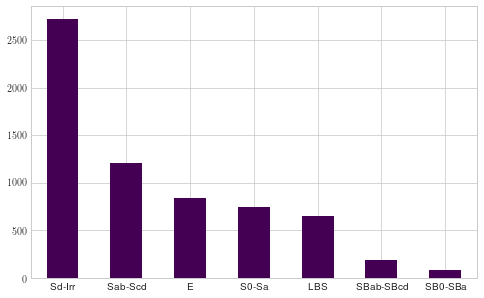

In [9]:
#plotting the frequency of the different Hubble types
plot=pd.Series(vm['HUBBLE_TYPE']).value_counts().plot('bar',colormap='viridis',rot=0,figsize=(8,5))
fig = plot.get_figure()
fig.savefig("hubble-type-frequency.png")

In [8]:
#merges the dataframes based on CATAID 
df1=pd.merge(sml,sc, on='CATAID')
df2= pd.merge(mp,df1, on='CATAID')
df3=pd.merge(df2,vm,on='CATAID')


In [11]:
len(df3) #galaxies in data set with a Hubble type

6418

In [9]:
#CREATE DISTANCE COLUMN
c=3e8 #m/s
h_0=(70/3.09e19) #converting hubble parameter to seconds
df3['dist']=df3['Z_TONRY']*c/h_0
df3['dist']=df3['dist']/3.086e16 #convert to parsecs

In [10]:
#GET LOG_R
df3['r_s_one']=df3['GALRE_r']*df3['dist'] #r1/2 in AU
df3['r_s_one']=df3['r_s_one']/206265 #need to convert to pc

#logs of columns
df3['log_r']=np.log10(df3['r_s_one'])
df3['log_mass']=np.log10(df3['mass_stellar_best_fit'])
df3['log_SFR']=np.log10(df3['SFR_0_1Gyr_best_fit'])
df3['log_lum']=np.log10(df3['L_dust_best_fit'])

In [11]:
#filter relevent columns
phys=df3.filter(['log_mass','log_SFR','log_lum','metalicity_Z_Zo_percentile50','log_r','GALINDEX_r'])

In [12]:
#define inter-quartile range
Q1 = phys.quantile(0.25)
Q3 = phys.quantile(0.75)
IQR = Q3 - Q1
#get rid of outliers 
phys= phys[~((phys < (Q1 - 2.5 * IQR)) |(phys > (Q3 + 2.5 * IQR))).any(axis=1)]

In [13]:
#standardising the data
col_names = phys.columns
scaler = preprocessing.StandardScaler().fit(phys)
stand_phys=scaler.fit_transform(phys)
#forming the pandas dataframe
stand_phys = pd.DataFrame(stand_phys, columns=col_names)

In [91]:
#covariance matrix of scaled data
cov_phys=np.cov(stand_phys.T)
#eigenvalues and eignenvectors of covariance matrix
eig_val,eig_vec=np.linalg.eig(cov_phys)

In [92]:
#calculating the explained variance and cumulative explained variance
tot = sum(eig_val)
var_exp = [(i / tot)*100 for i in sorted(eig_val, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)

[ 47.69109525  70.75929024  83.84784217  93.33330337  98.20946094
 100.        ]


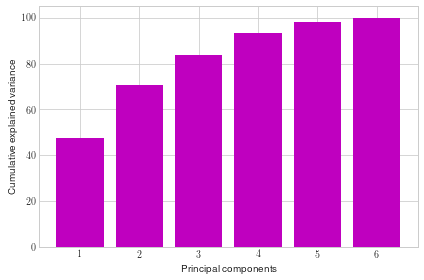

In [93]:
#plotting the cumulative explained variance
pc=np.array([1,2,3,4,5,6])
plt.bar(pc, cum_var_exp,label='cumulative explained variance',color='m')
plt.ylabel('Cumulative explained variance')
plt.xlabel('Principal components')
plt.tight_layout()
plt.savefig('pca-var.png',bbox_inches='tight')

In [152]:
#perform the PCA
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=3,whiten='true')
phys_pca = sklearn_pca.fit_transform(stand_phys)

#PCA with no whiten=true
sklearn_pca2 = sklearnPCA(n_components=3)
phys_pca2 = sklearn_pca2.fit_transform(stand_phys)

In [176]:
#performing kmeans for k=2 to k=20, and calculate and save the inertia, calinski-harabasz score and davies-bouldin score
inertias = [] 
K=np.arange(2,16)
chs=[]
dbs=[]
for k in K:    
    kmeans_plus=KMeans(n_clusters=k,init='k-means++',n_init=100).fit(phys_pca)
    inertias.append(kmeans_plus.inertia_) 
    labels=kmeans_plus.labels_
    chs.append(calinski_harabasz_score(phys_pca, labels))
    dbs.append(davies_bouldin_score(phys_pca,labels))

In [26]:
#using data without PCA
inertias2=[] 
chs2=[]
dbs2=[]

for k in K:    
    kmeans_plus=KMeans(n_clusters=k,init='k-means++',n_init=100).fit(stand_phys)
    inertias2.append(kmeans_plus.inertia_) 
    labels2=kmeans_plus.labels_   
    chs2.append(calinski_harabasz_score(stand_phys, labels2))
    dbs2.append(davies_bouldin_score(stand_phys,labels2))

In [27]:
#using whiten=false PCA data 
inertias3=[] 
chs3=[]
dbs3=[]
for k in K:    
    kmeans_plus=KMeans(n_clusters=k,init='k-means++',n_init=100).fit(phys_pca2)
    inertias3.append(kmeans_plus.inertia_) 
    labels3=kmeans_plus.labels_
    chs3.append(calinski_harabasz_score(phys_pca2, labels3))
    dbs3.append(davies_bouldin_score(phys_pca2,labels3))

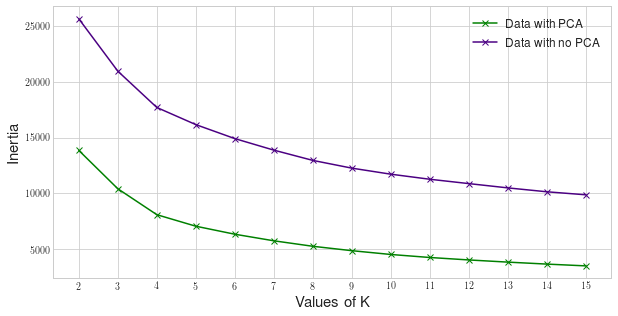

In [123]:
#inertia elbow plot
plt.figure(figsize=(10,5))    
plt.plot(K,inertias,'x-',color='green',label='Data with PCA')
plt.plot(K,inertias2, 'x-', color='indigo',label='Data with no PCA') 

plt.xticks([2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Values of K',fontsize=15) 
plt.ylabel('Inertia',fontsize=15) 
plt.legend(fontsize=12)
plt.savefig('inertia.jpg',bbox_inches='tight')
plt.show() 

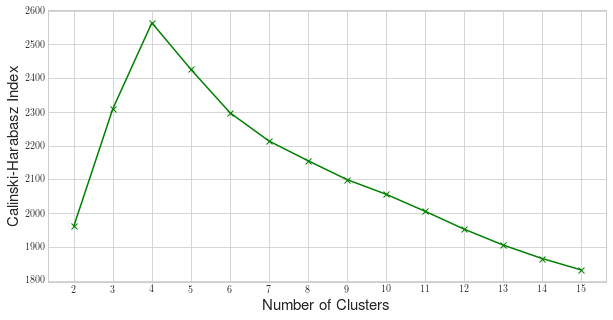

In [177]:
#calinski-harabasz index plot
plt.figure(figsize=(10,5))
plt.plot(K,chs,'x-',color='green')
plt.xticks([2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Number of Clusters',fontsize=15)
plt.ylabel('Calinski-Harabasz Index',fontsize=15)
plt.savefig('chs.jpg',bbox_inches='tight')
plt.show()

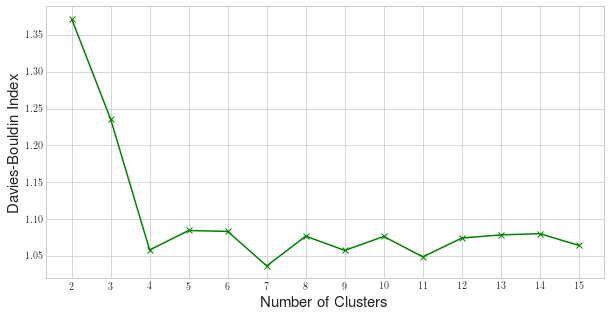

In [178]:
#davies-bouldin index
plt.figure(figsize=(10,5))
plt.plot(K,dbs,'x-',color='green')
plt.xticks([2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Number of Clusters',fontsize=15)
plt.ylabel('Davies-Bouldin Index',fontsize=15)
plt.savefig('dbs.jpg',bbox_inches='tight')
plt.show()

In [95]:
#kmeans clustering with k=4
kmeans_plus_4=KMeans(n_clusters=4,init='k-means++',n_init=100).fit(phys_pca)

In [179]:
#getting the cluster labels and centers
labels4=kmeans_plus_4.labels_
centers4=kmeans_plus_4.cluster_centers_

In [181]:
labels_array=np.array([labels4])
label_array=np.sort(labels_array)

In [165]:
unique,counts=np.unique(labels_array,return_counts='True')
label_counts=np.asarray((unique,counts))
print(unique,counts)

[0 1 2 3] [1391 2091 1739  883]


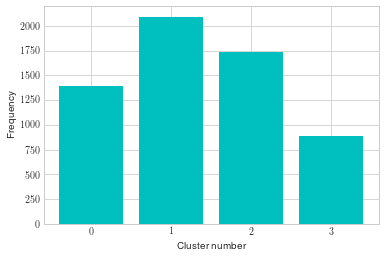

In [167]:
plt.bar(unique,counts,color='c')
plt.xticks([0,1,2,3])
plt.xlabel('Cluster number')
plt.ylabel('Frequency')
plt.savefig('k4hist.png',bbox_inches='tight')

In [168]:
xvector=sklearn_pca.components_.T[:,0]
yvector=sklearn_pca.components_.T[:,1]
zvector=sklearn_pca.components_.T[:,2]
xs=phys_pca[:,0]
ys=phys_pca[:,1]
zs=phys_pca[:,2]

In [169]:
print(xvector)
print(yvector)
print(zvector)

[-0.47606177 -0.41914136 -0.53023893 -0.3370138  -0.43094799 -0.13129323]
[ 0.35882757 -0.47582054 -0.21696117  0.2387495  -0.07619848  0.73140817]
[-0.18461564  0.12899783  0.03728232  0.79379934 -0.54835114 -0.1306916 ]


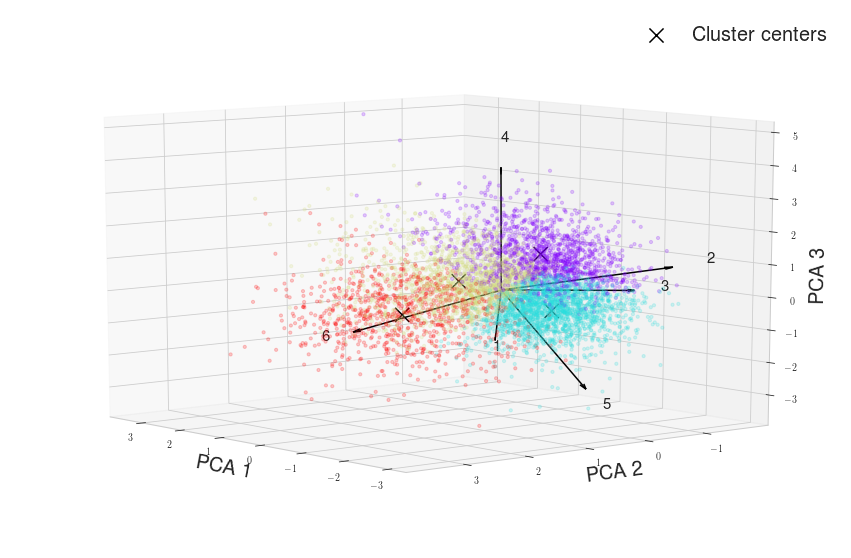

In [170]:
#plotting the biplot for k=4
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(phys_pca[:,0],phys_pca[:,1],phys_pca[:,2], c=labels4,cmap='rainbow',s=10,alpha=0.2,zorder=0)
ax.set_xlabel('PCA 1',fontsize=20)
ax.set_ylabel('PCA 2',fontsize=20)
ax.set_zlabel('PCA 3',fontsize=20)
ax.set_xlim3d(np.min(phys_pca[:,0]),np.max(phys_pca[:,0]))
ax.set_ylim3d(np.min(phys_pca[:,1]),np.max(phys_pca[:,1]))
ax.set_zlim3d(np.min(phys_pca[:,2]),np.max(phys_pca[:,2]))
ax.scatter(centers4[:, 0], centers4[:, 1],centers4[:,2],marker='x', c='black', s=200,alpha=1,label='Cluster centers',zorder=1)
for i in range(len(xvector)):

    ax.quiver(0, 0, 0, xvector[i]*max(xs), yvector[i]*max(ys), zvector[i]*max(zs), color='black',arrow_length_ratio=0.05)
    
    ax.text(xvector[i]*max(xs)*1.2,yvector[i]*max(ys)*1.2,zvector[i]*max(zs)*1.2, i+1,fontsize=15)
    
ax.view_init(elev=10,azim=140)
ax.legend(loc='upper right',fontsize=20)

plt.show()
fig.savefig('k43Dbi-plot.png',bbox_inches='tight')

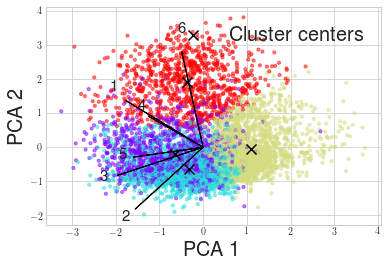

In [171]:
plt.scatter(phys_pca[:,0],phys_pca[:,1], c=labels4, s=10, cmap='rainbow',alpha=0.5)
plt.xlabel('PCA 1',fontsize=20)
plt.ylabel('PCA 2',fontsize=20)

plt.scatter(centers4[:, 0], centers4[:, 1],marker='x', c='black', s=100,alpha=1,label='Cluster centers');
plt.legend()

for i in range(len(xvector)):

    plt.arrow(0,0, xvector[i]*max(xs), yvector[i]*max(ys), color='black')
    
    plt.text(xvector[i]*max(xs)*1.2,yvector[i]*max(ys)*1.2, i+1,fontsize=15)
    

plt.legend(loc='upper right',fontsize=20)

plt.savefig('k42dplot-1v2.png',bbox_inches='tight')
plt.show()

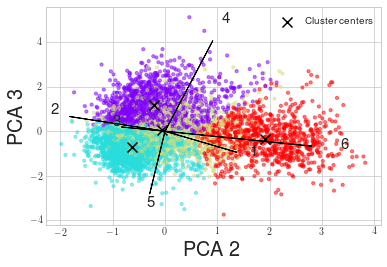

In [172]:
plt.scatter(phys_pca[:,1],phys_pca[:,2], c=labels4, s=10, cmap='rainbow',alpha=0.5)
plt.xlabel('PCA 2',fontsize=20)
plt.ylabel('PCA 3',fontsize=20)

plt.scatter(centers4[:, 1], centers4[:, 2],marker='x', c='black', s=100,alpha=1,label='Cluster centers')

for i in range(len(yvector)):

    plt.arrow(0,0, yvector[i]*max(ys), zvector[i]*max(zs), color='black')
    
    plt.text(yvector[i]*max(ys)*1.2,zvector[i]*max(zs)*1.2, i+1,fontsize=15)
    
plt.legend()
plt.savefig('k42dplot-2v3.png',bbox_inches='tight')
plt.show()


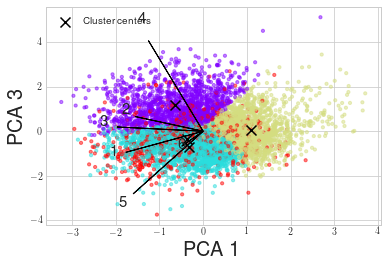

In [173]:
plt.scatter(phys_pca[:,0],phys_pca[:,2], c=labels4, s=10, cmap='rainbow',alpha=0.5)
plt.xlabel('PCA 1',fontsize=20)
plt.ylabel('PCA 3',fontsize=20)

plt.scatter(centers4[:, 0], centers4[:, 2],marker='x', c='black', s=100,alpha=1,label='Cluster centers')

for i in range(len(xvector)):

    plt.arrow(0,0, xvector[i]*max(xs), zvector[i]*max(zs), color='black')
    
    plt.text(xvector[i]*max(xs)*1.2,zvector[i]*max(zs)*1.2, i+1,fontsize=15)
    
plt.legend()
plt.savefig('k42dplot-1v3.png',bbox_inches='tight')
plt.show()


In [110]:
#setting up box plot
pc1_df=pd.DataFrame(phys_pca[:,0],index=labels4) #create df of pc1, indexed by their cluster label
pc1_1=pc1_df.loc[0]
pc1_2=pc1_df.loc[1]
pc1_3=pc1_df.loc[2]
pc1_4=pc1_df.loc[3]

In [111]:
pc1_1.columns=['1']
pc1_2.columns=['2']
pc1_3.columns=['3']
pc1_4.columns=['4']

pc1_1.reset_index(drop=True, inplace=True)
pc1_2.reset_index(drop=True, inplace=True)
pc1_3.reset_index(drop=True, inplace=True)
pc1_4.reset_index(drop=True, inplace=True)

In [112]:
pc1_1['Data'] = 1
pc1_2['Data'] = 2
pc1_3['Data'] = 3
pc1_4['Data'] = 4



C:\Users\naomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\naomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\naomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

In [113]:
pc1_s=[pc1_1,pc1_2,pc1_3,pc1_4]
pc1_all=pd.concat(pc1_s,sort=False)

In [114]:
pc1_all=pc1_all.drop(['Data'],axis=1)

In [115]:
pc1_all.columns

Index(['1', '2', '3', '4'], dtype='object')

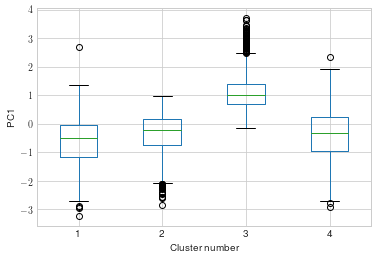

In [116]:
pc1_all.boxplot()
plt.xlabel('Cluster number')
plt.ylabel('PC1')
plt.savefig('pc1-boxplot.png',bbox_inches='tight')

In [117]:
pc2_df=pd.DataFrame(phys_pca[:,1],index=labels4) #create df of pc1, indexed by their cluster label
pc2_1=pc2_df.loc[0]
pc2_2=pc2_df.loc[1]
pc2_3=pc2_df.loc[2]
pc2_4=pc2_df.loc[3]

pc2_1.columns=['1']
pc2_2.columns=['2']
pc2_3.columns=['3']
pc2_4.columns=['4']

pc2_1.reset_index(drop=True, inplace=True)
pc2_2.reset_index(drop=True, inplace=True)
pc2_3.reset_index(drop=True, inplace=True)
pc2_4.reset_index(drop=True, inplace=True)

In [118]:
pc2_1['Data'] = 1
pc2_2['Data'] = 2
pc2_3['Data'] = 3
pc2_4['Data'] = 4


C:\Users\naomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\naomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\naomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

In [119]:
pc2_s=[pc2_1,pc2_2,pc2_3,pc2_4]
pc2_all=pd.concat(pc2_s,sort=False)
pc2_all=pc2_all.drop(['Data'],axis=1)

,1,2,3,4
0,-0.708572,NaN,NaN,NaN
1,0.502878,NaN,NaN,NaN
2,0.055832,NaN,NaN,NaN
3,-0.290229,NaN,NaN,NaN
4,-0.664988,NaN,NaN,NaN


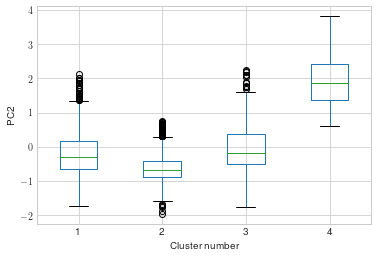

In [120]:
pc2_all.boxplot()
plt.xlabel('Cluster number')
plt.ylabel('PC2')
plt.savefig('pc2-boxplot.png',bbox_inches='tight')

In [121]:
pc3_df=pd.DataFrame(phys_pca[:,2],index=labels4) #create df of pc1, indexed by their cluster label
pc3_1=pc3_df.loc[0]
pc3_2=pc3_df.loc[1]
pc3_3=pc3_df.loc[2]
pc3_4=pc3_df.loc[3]

pc3_1.columns=['1']
pc3_2.columns=['2']
pc3_3.columns=['3']
pc3_4.columns=['4']

pc3_1.reset_index(drop=True, inplace=True)
pc3_2.reset_index(drop=True, inplace=True)
pc3_3.reset_index(drop=True, inplace=True)
pc3_4.reset_index(drop=True, inplace=True)

pc3_1['Data'] = 1
pc3_2['Data'] = 2
pc3_3['Data'] = 3
pc3_4['Data'] = 4

pc3_s=[pc3_1,pc3_2,pc3_3,pc3_4]
pc3_all=pd.concat(pc3_s,sort=False)
pc3_all=pc3_all.drop(['Data'],axis=1)


C:\Users\naomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\naomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\naomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

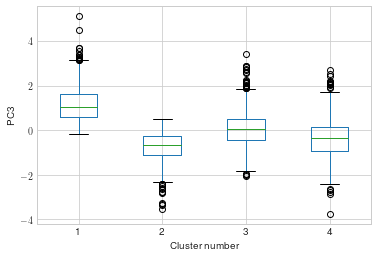

In [122]:
pc3_all.boxplot()
plt.xlabel('Cluster number')
plt.ylabel('PC3')
plt.savefig('pc3-boxplot.png',bbox_inches='tight')

In [131]:
sklearn_pca.components_ 

array([[-0.47606177, -0.41914136, -0.53023893, -0.3370138 , -0.43094799,
        -0.13129323],
       [ 0.35882757, -0.47582054, -0.21696117,  0.2387495 , -0.07619848,
         0.73140817],
       [-0.18461564,  0.12899783,  0.03728232,  0.79379934, -0.54835114,
        -0.1306916 ]])